## New Excel Sheet, Back to Four Models, Only UPDRS, Age and Sex

From request [Run for models with 1002 except sheet for only updrs sex and age](https://trello.com/c/agnyJB4M)

New Data Sheet.  Back to MSA vs Rest and PSP vs Rest

## Imports and Function Definitions

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support, roc_curve, make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, train_test_split, LeaveOneOut, GridSearchCV, cross_validate
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

def grid_search_optimization(model, tuned_parameters, X, y, Xh, yh, cv=5, scoring='accuracy', verbose=False):
    print("# Tuning hyper-parameters for %s" %scoring)
    print()

    clf = GridSearchCV(model, tuned_parameters, cv=cv, n_jobs = -1, scoring=scoring, verbose=1)
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    if verbose:
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

    print("Detailed classification report (holdout):")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = yh, clf.predict(Xh)
    print(classification_report(y_true, y_pred))
    print()
    
    get_metrics(clf.best_estimator_, Xh, yh)
    
    return clf

def group_classes(data, grouping):
        classes_to_keep = grouping.keys()
        data_to_keep = data.loc[data['GroupID'].isin(classes_to_keep)]
        classes_to_change = {k:grouping[k] for k in classes_to_keep if k!= grouping[k]}
        return data_to_keep.replace(classes_to_change)
    
def plot_coefficients(classifier, feature_names, top_features=20):
     coef = classifier.coef_.ravel()
     top_positive_coefficients = np.argsort(coef)[-top_features:]
     top_negative_coefficients = np.argsort(coef)[:top_features]
     top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
     # create plot
     plt.figure(figsize=(15, 5))
     colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
     plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
     feature_names = np.array(feature_names)
     plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
     plt.show()
        
def print_feature_importance(feature_names, coefs):
    assert len(feature_names) == len(coefs), "Arrays have difference lengths. Something went wrong"
    for feature, coef in zip(feature_names, coefs):
        print("%s\t%s" %(feature, coef))
        
# AKA True Negative Rate
def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[0,:].sum()

def negative_predictive_value(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[:,0].sum()

def plot_roc(model, X_test, Y_test):
    y_true, y_pred = Y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred))

    y_pred_prob = model.predict_proba(X_test)[:,1]

    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)

    plt.plot([0,1],[0,1], 'k--')
    plt.plot(fpr, tpr, label='Linear SVC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Linear SVC ROC Curve')
    plt.show()
    
    for a,b in zip(fpr, tpr):
        print(a,b)
    
def get_metrics(model, X, y):
    for metric in _scoring_list:
        score = _scoring_list[metric](model, X, y)
        print("%s\t%s" %(metric, score))

## Define classifier, pipeline and constants

In [2]:
param_grid = {
    "classifier__C": np.logspace(-5, 2, 20),
#     "PCA__n_components": range(1,113,10),
#     "fss__k": range(1,115,3),
},

clf = Pipeline([
#     ('Norm', Normalizer()),\n",
#     ("Oversample", RandomOverSampler()),
#     ('PCA', PCA()),
    ('Scaler', StandardScaler()),
#     ('fss',SelectKBest()),
    ('classifier', SVC(kernel='linear', class_weight='balanced', probability=True))
])

_cv=5
_test_size=0.20
_scoring_list={
    'recall':make_scorer(recall_score),
    'precision':make_scorer(precision_score),
    'auc':make_scorer(roc_auc_score),
    'specificity':make_scorer(specificity),
    'npv':make_scorer(negative_predictive_value),
    'accuracy':make_scorer(accuracy_score)
}

_scoring='f1_micro'
_data = pd.read_excel('1002_Data_no_Subj_Site.xlsx')
_data = _data[['GroupID', 'Age', 'Sex', 'UPDRS']]
_random_seed = 55

## 1. Control vs. PD/MSA/PSP

In [3]:
# Get the data
data1 = group_classes(_data, {0:0, 1:1, 2:1, 3:1})

y1 = data1['GroupID']
X1 = data1.drop(['GroupID'], axis=1)

X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, y1, test_size=_test_size, random_state=_random_seed)

best1 = grid_search_optimization(clf, param_grid, X_train1, Y_train1, X_test1, Y_test1, cv=_cv, scoring=_scoring)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.1s


Best parameters set found on development set:

{'classifier__C': 0.26366508987303555}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

         0.0       0.84      0.95      0.89        55
         1.0       0.98      0.93      0.95       146

   micro avg       0.94      0.94      0.94       201
   macro avg       0.91      0.94      0.92       201
weighted avg       0.94      0.94      0.94       201


recall	0.9315068493150684
precision	0.9784172661870504
auc	0.9384806973848069
specificity	0.9454545454545454
npv	0.8387096774193549
accuracy	0.9353233830845771


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.5s finished
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [4]:
scores = cross_validate(best1.best_estimator_, X_train1, Y_train1, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.03759951591491699	0.02149099740283515
score_time	0.007801532745361328	0.000980738527324139
test_recall	0.956776611694153	0.01442623241838163
train_recall	0.9524248969173374	0.003835067630801343
test_precision	0.9895020489123327	0.01010732197059653
train_precision	0.989226358128761	0.0025877776324531965
test_auc	0.964903457362228	0.00701108180469516
train_auc	0.9627575492056402	0.003446539658362862
test_specificity	0.973030303030303	0.026385880162925174
train_specificity	0.9730902014939427	0.0065423692271858475
test_npv	0.8985331008968883	0.029899825680859447
train_npv	0.8876158026253714	0.007907297801961366
test_accuracy	0.9613188015156842	0.00450016222419838
train_accuracy	0.9581795171339562	0.002992558491983448


In [5]:
model = best1.best_estimator_.named_steps['classifier']
feature_names = data1.columns.tolist()[1:]
# plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

Age	-0.2889637798864278
Sex	-0.08041643682329067
UPDRS	3.1138206301685525


              precision    recall  f1-score   support

         0.0       0.84      0.95      0.89        55
         1.0       0.98      0.93      0.95       146

   micro avg       0.94      0.94      0.94       201
   macro avg       0.91      0.94      0.92       201
weighted avg       0.94      0.94      0.94       201



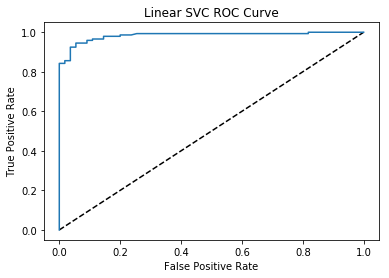

0.0 0.0
0.0 0.07534246575342465
0.0 0.7876712328767124
0.0 0.8013698630136986
0.0 0.8424657534246576
0.01818181818181818 0.8424657534246576
0.01818181818181818 0.8561643835616438
0.03636363636363636 0.8561643835616438
0.03636363636363636 0.8698630136986302
0.03636363636363636 0.8835616438356164
0.03636363636363636 0.9246575342465754
0.05454545454545454 0.9246575342465754
0.05454545454545454 0.9452054794520548
0.09090909090909091 0.9452054794520548
0.09090909090909091 0.958904109589041
0.10909090909090909 0.958904109589041
0.10909090909090909 0.9657534246575342
0.14545454545454545 0.9657534246575342
0.14545454545454545 0.9794520547945206
0.16363636363636364 0.9794520547945206
0.2 0.9794520547945206
0.2 0.9863013698630136
0.23636363636363636 0.9863013698630136
0.2545454545454545 0.9931506849315068
0.6909090909090909 0.9931506849315068
0.7272727272727273 0.9931506849315068
0.8181818181818182 0.9931506849315068
0.8181818181818182 1.0
0.8545454545454545 1.0
0.8727272727272727 1.0
0.90909090

In [6]:
plot_roc(best1.best_estimator_, X_test1, Y_test1)

## 2. PD vs MSA/PSP

In [7]:
# Get the data
data2 = group_classes(_data, {1:0, 2:1, 3:1})

y2 = data2['GroupID']
X2 = data2.drop(['GroupID'], axis=1)

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, y2, test_size=_test_size, random_state=_random_seed)

best2 = grid_search_optimization(clf, param_grid, X_train2, Y_train2, X_test2, Y_test2, cv=_cv, scoring=_scoring)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best parameters set found on development set:

{'classifier__C': 0.001623776739188721}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

         0.0       0.84      0.66      0.74       105
         1.0       0.43      0.68      0.52        40

   micro avg       0.66      0.66      0.66       145
   macro avg       0.64      0.67      0.63       145
weighted avg       0.73      0.66      0.68       145


recall	0.675
precision	0.42857142857142855
auc	0.6660714285714286
specificity	0.6571428571428571
npv	0.8414634146341463
accuracy	0.6620689655172414


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.4s finished
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [8]:
scores = cross_validate(best2.best_estimator_, X_train2, Y_train2, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.034799623489379886	0.021075420363727684
score_time	0.03200063705444336	0.027018560591686863
test_recall	0.41529411764705876	0.09851435085837831
train_recall	0.4321238661244918	0.10824499326961591
test_precision	0.5500946305156832	0.11057163195483907
train_precision	0.5605471452277654	0.04141865560994606
test_auc	0.6299746709885399	0.042009067138317195
train_auc	0.6415605085608214	0.029769641805045367
test_specificity	0.844655224330021	0.06855174979357405
train_specificity	0.850997150997151	0.05791737324151579
test_npv	0.7735849631508883	0.024673009126600132
train_npv	0.7807435376239746	0.024581265573014738
test_accuracy	0.7165298120170684	0.03952534243510153
train_accuracy	0.7258010326482435	0.016519975491548555


In [9]:
model = best2.best_estimator_.named_steps['classifier']
feature_names = data2.columns.tolist()[1:]
# plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

Age	0.1853071637559382
Sex	0.0
UPDRS	0.3559341458899825


              precision    recall  f1-score   support

         0.0       0.84      0.66      0.74       105
         1.0       0.43      0.68      0.52        40

   micro avg       0.66      0.66      0.66       145
   macro avg       0.64      0.67      0.63       145
weighted avg       0.73      0.66      0.68       145



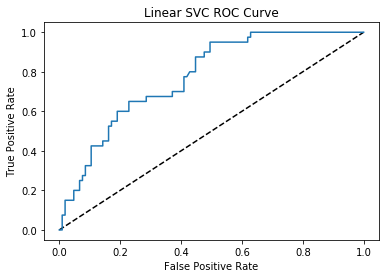

0.0 0.0
0.009523809523809525 0.0
0.009523809523809525 0.075
0.01904761904761905 0.075
0.01904761904761905 0.15
0.047619047619047616 0.15
0.047619047619047616 0.2
0.06666666666666667 0.2
0.06666666666666667 0.25
0.0761904761904762 0.25
0.0761904761904762 0.275
0.08571428571428572 0.275
0.08571428571428572 0.325
0.10476190476190476 0.325
0.10476190476190476 0.425
0.14285714285714285 0.425
0.14285714285714285 0.45
0.1619047619047619 0.45
0.1619047619047619 0.525
0.17142857142857143 0.525
0.17142857142857143 0.55
0.19047619047619047 0.55
0.19047619047619047 0.6
0.22857142857142856 0.6
0.22857142857142856 0.65
0.2857142857142857 0.65
0.2857142857142857 0.675
0.37142857142857144 0.675
0.37142857142857144 0.7
0.4095238095238095 0.7
0.4095238095238095 0.775
0.41904761904761906 0.775
0.42857142857142855 0.8
0.44761904761904764 0.8
0.44761904761904764 0.875
0.47619047619047616 0.875
0.47619047619047616 0.9
0.49523809523809526 0.9
0.49523809523809526 0.95
0.6190476190476191 0.95
0.619047619047619

In [10]:
plot_roc(best2.best_estimator_, X_test2, Y_test2)

## 3. MSA vs PD/PSP

In [11]:
# Get the data
data3 = group_classes(_data, {1:0, 3:0, 2:1})

y3 = data3['GroupID']
X3 = data3.drop(['GroupID'], axis=1)

X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X3, y3, test_size=_test_size, random_state=_random_seed)

best3 = grid_search_optimization(clf, param_grid, X_train3, Y_train3, X_test3, Y_test3, cv=_cv, scoring=_scoring)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best parameters set found on development set:

{'classifier__C': 0.001623776739188721}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

         0.0       0.96      0.73      0.83       131
         1.0       0.22      0.71      0.34        14

   micro avg       0.73      0.73      0.73       145
   macro avg       0.59      0.72      0.59       145
weighted avg       0.89      0.73      0.78       145


recall	0.7142857142857143
precision	0.2222222222222222
auc	0.7235550708833152
specificity	0.732824427480916
npv	0.96
accuracy	0.7310344827586207


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.2s finished
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [12]:
scores = cross_validate(best3.best_estimator_, X_train3, Y_train3, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.037800025939941403	0.02723517002004778
score_time	0.03460054397583008	0.024896994948119113
test_recall	0.48571428571428565	0.19378085666072192
train_recall	0.5357142857142858	0.08222046023729528
test_precision	0.3189168573607933	0.10513108153513662
train_precision	0.34785819419178726	0.03943118833508366
test_auc	0.6721233047674515	0.10077150437632795
train_auc	0.6968840976193917	0.02812968202373567
test_specificity	0.8585323238206174	0.03321659580168721
train_specificity	0.8580539095244977	0.04080457750086697
test_npv	0.9243711119991873	0.027321863280464553
train_npv	0.9311323477210076	0.009357245495926108
test_accuracy	0.8134182908545726	0.04019794734884102
train_accuracy	0.8190818872421242	0.02874764853941205


In [13]:
model = best3.best_estimator_.named_steps['classifier']
feature_names = data3.columns.tolist()[1:]
# plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

Age	0.015361505087372853
Sex	0.0
UPDRS	0.4505458174489426


              precision    recall  f1-score   support

         0.0       0.96      0.73      0.83       131
         1.0       0.22      0.71      0.34        14

   micro avg       0.73      0.73      0.73       145
   macro avg       0.59      0.72      0.59       145
weighted avg       0.89      0.73      0.78       145



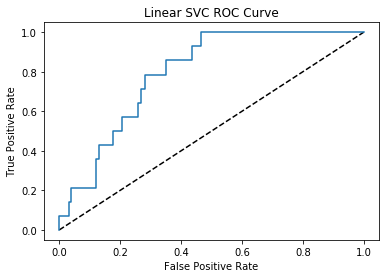

0.0 0.0
0.0 0.07142857142857142
0.030534351145038167 0.07142857142857142
0.030534351145038167 0.14285714285714285
0.03816793893129771 0.14285714285714285
0.03816793893129771 0.21428571428571427
0.12213740458015267 0.21428571428571427
0.12213740458015267 0.35714285714285715
0.1297709923664122 0.35714285714285715
0.1297709923664122 0.42857142857142855
0.16030534351145037 0.42857142857142855
0.17557251908396945 0.42857142857142855
0.17557251908396945 0.5
0.20610687022900764 0.5
0.20610687022900764 0.5714285714285714
0.2595419847328244 0.5714285714285714
0.2595419847328244 0.6428571428571429
0.26717557251908397 0.6428571428571429
0.26717557251908397 0.7142857142857143
0.2824427480916031 0.7142857142857143
0.2824427480916031 0.7857142857142857
0.3511450381679389 0.7857142857142857
0.3511450381679389 0.8571428571428571
0.4351145038167939 0.8571428571428571
0.4351145038167939 0.9285714285714286
0.46564885496183206 0.9285714285714286
0.46564885496183206 1.0
0.48091603053435117 1.0
0.4961832061

In [14]:
plot_roc(best3.best_estimator_, X_test3, Y_test3)

## 4. PSP vs PD/MSA

In [15]:
# Get the data
data4 = group_classes(_data, {1:0, 2:0, 3:1})

y4 = data4['GroupID']
X4 = data4.drop(['GroupID'], axis=1)

X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X4, y4, test_size=_test_size, random_state=_random_seed)

best4 = grid_search_optimization(clf, param_grid, X_train4, Y_train4, X_test4, Y_test4, cv=_cv, scoring=_scoring)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best parameters set found on development set:

{'classifier__C': 0.001623776739188721}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

         0.0       0.91      0.70      0.79       119
         1.0       0.33      0.69      0.45        26

   micro avg       0.70      0.70      0.70       145
   macro avg       0.62      0.69      0.62       145
weighted avg       0.81      0.70      0.73       145


recall	0.6923076923076923
precision	0.3333333333333333
auc	0.6948933419521655
specificity	0.6974789915966386
npv	0.9120879120879121
accuracy	0.696551724137931


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [16]:
scores = cross_validate(best4.best_estimator_, X_train4, Y_train4, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.03379950523376465	0.021255134586790427
score_time	0.017001247406005858	0.016515882664208625
test_recall	0.5114285714285715	0.26179824673871455
train_recall	0.4809285924184543	0.22116783256673267
test_precision	0.27428774928774924	0.07641703337973897
train_precision	0.2601514629317284	0.035835020870091445
test_auc	0.5969313909774436	0.0554553437963716
train_auc	0.5771565188919181	0.01987514132375891
test_specificity	0.6824342105263158	0.2136385500217638
train_specificity	0.673384445365382	0.23053533025807854
test_npv	0.885746169631819	0.060181472418808925
train_npv	0.8665846190161071	0.02789162758260514
test_accuracy	0.6527372211330232	0.13368374286826598
train_accuracy	0.6389973705820507	0.1511071402133326


In [17]:
model = best4.best_estimator_.named_steps['classifier']
feature_names = data4.columns.tolist()[1:]
# plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

Age	0.25927273602288253
Sex	0.0
UPDRS	0.15470416631031508


              precision    recall  f1-score   support

         0.0       0.91      0.70      0.79       119
         1.0       0.33      0.69      0.45        26

   micro avg       0.70      0.70      0.70       145
   macro avg       0.62      0.69      0.62       145
weighted avg       0.81      0.70      0.73       145



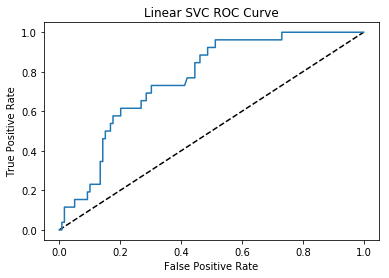

0.0 0.0
0.008403361344537815 0.0
0.008403361344537815 0.038461538461538464
0.01680672268907563 0.038461538461538464
0.01680672268907563 0.11538461538461539
0.05042016806722689 0.11538461538461539
0.05042016806722689 0.15384615384615385
0.09243697478991597 0.15384615384615385
0.09243697478991597 0.19230769230769232
0.10084033613445378 0.19230769230769232
0.10084033613445378 0.23076923076923078
0.13445378151260504 0.23076923076923078
0.13445378151260504 0.34615384615384615
0.14285714285714285 0.34615384615384615
0.14285714285714285 0.46153846153846156
0.15126050420168066 0.46153846153846156
0.15126050420168066 0.5
0.16806722689075632 0.5
0.16806722689075632 0.5384615384615384
0.17647058823529413 0.5384615384615384
0.17647058823529413 0.5769230769230769
0.20168067226890757 0.5769230769230769
0.20168067226890757 0.6153846153846154
0.2689075630252101 0.6153846153846154
0.2689075630252101 0.6538461538461539
0.2857142857142857 0.6538461538461539
0.2857142857142857 0.6923076923076923
0.3025210

In [18]:
plot_roc(best4.best_estimator_, X_test4, Y_test4)